# Abstractive Text Summarization with Seq2Seq Using PyTorch
This notebook aims to perform abstractive text summarization for article-title pairs using PyTorch. In other words the goal is to make use of the `article-title` pair information to train a seq2seq model for predicting (summarizing) a suitable title for a news story. Abstractive text summarization is challenging because in this scenario the model can generate a summary based on an actual abstracted summary and can even use words that are not present in the original input. The techniques that will be used in this tutorial are adopted from the paper ["Abstractive Text Summarization using Sequence-to-sequence RNNs and Beyond"](https://arxiv.org/pdf/1602.06023.pdf).

In this tutorial you will learn the following:
- Implement LSTMs, GRUs, biLSTMS, etc.
- Text processing using spaCy
- Batch data processing
- Implement attention mechanism
- Use pretrained vectors from GloVe
- Sample with attention plots

## Setup
Let's first install all the necessary libraries such as PyTorch and fastai.

In [1]:
#!pip install fastai==0.7.0
#!pip install torch==0.4.1
#!pip install spacy

## 1. Data Exploration
Before diving deep with your models and data, it's always important to explore your data and understand its properties. To load our data, we are going to use [torchtext](https://github.com/pytorch/text), but you can choose to use any data processing library you wish. Torchtext will allow us to keep this tutorial simple since it already offers a lot of functions, such as padding and numericalization, to process our dataset.

In [2]:
#import data, vocab from torchtext 
from torchtext import data, vocab
import spacy.cli
spacy.cli.download("en")


    Linking successful
    /home/ellfae/anaconda3/lib/python3.6/site-packages/en_core_web_sm -->
    /home/ellfae/anaconda3/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [3]:
%matplotlib inline

In [4]:
# directory path to dataset
DATA_PATH = 'data/'
SAMPLE_DATA_PATH = f'{DATA_PATH}sample_data/'
PROCESSED_DATA_PATH = f'{DATA_PATH}processed_data/'

One thing to keep in mind is that this will be a computation heavy NLP task. So we would like to first test our models with a sample of the original dataset. We have generated a sample of our training and testing datasets already. You can also obtain the original dataset used for this tutorial [here](https://drive.google.com/file/d/0B6N7tANPyVeBNmlSX19Ld2xDU1E/view). 

In the code below, we are using the spaCy tokenizer and we are converting our dataset to a nice format. 

In [5]:
tokenizer = data.get_tokenizer('spacy')
TEXT = data.Field(tokenize=tokenizer, lower=True, eos_token='_eos_')
trn_data_fields = [("source", TEXT),
                   ("target", TEXT)]

trn, vld = data.TabularDataset.splits(path=f'{SAMPLE_DATA_PATH}',
                                     train='train_ds.csv', validation='valid_ds.csv',
                                     format='csv', skip_header=True, fields=trn_data_fields)

In [6]:
# Let's print out an example using the loaders we defined above
for i in range(3):
    print("Source:", trn[i].source)
    print("Target:", trn[i].target)

Source: ['the', 'government', 'credited', 'new', 'zealand', "'s", 'reputation', 'for', 'having', 'a', 'pristine', 'environment', 'for', 'the', 'nearly', '#', 'percent', 'rise', 'in', 'tourism', 'revenue', 'for', 'the', 'year', 'through', 'march', '#', '#', '#', '#', 'to', 'a', 'record', 'of', 'more', 'than', 'us$', '#', '#', 'billion', '-lrb-', 'nz$', '#', '#', 'billion', '-rrb-', '.']
Target: ['new', 'zealand', 'tourism', 'revenue', 'rises', 'nearly', '#', 'percent', 'to', 'record', 'us$', '#', '#', '.', '#', 'billion']
Source: ['rep', '.', 'john', 'doolittle', "'s", 'practice', 'of', 'paying', 'a', '#', '#', 'percent', 'fundraising', 'commission', 'to', 'a', 'company', 'owned', 'by', 'his', 'wife', ',', 'julie', ',', 'has', 'come', 'under', 'attack', 'from', 'a', 'professional', 'association', 'of', 'fundraisers', '.']
Target: ['group', 'challenges', 'doolittle', 'wife', 'on', 'fundraising']
Source: ['the', 'government', 'raised', 'the', 'nationwide', 'terror', 'alert', 'to', 'its', 

We can see that the instances are already tokenized. That's great! Let's just get back the original to see the examples more clearly.

In [7]:
for i in range(3):
    print("Source:", " ".join(trn[i].source))
    print("Target:", " ".join(trn[i].target))
    print("\n")

Source: the government credited new zealand 's reputation for having a pristine environment for the nearly # percent rise in tourism revenue for the year through march # # # # to a record of more than us$ # # billion -lrb- nz$ # # billion -rrb- .
Target: new zealand tourism revenue rises nearly # percent to record us$ # # . # billion


Source: rep . john doolittle 's practice of paying a # # percent fundraising commission to a company owned by his wife , julie , has come under attack from a professional association of fundraisers .
Target: group challenges doolittle wife on fundraising


Source: the government raised the nationwide terror alert to its second - highest level , closed nine u.s . embassies overseas and heightened security at federal buildings and landmarks in america as new intelligence warned of car bombings , suicide attacks and other strikes linked to the sept . # # anniversary .
Target: bush administration warns of heightened threat for terrorist strike




There you go! Those are our `article-title` pairs.

## 2. Preprocess the dataset
Before we start setting up our models, we need to pre-process our dataset and transform it in a way that the models can understand. We will do things like tokenizing, generating vocabulary, creating dataset iterators, batching, padding, and much more.

### Build Vocabulary
One key step in any NLP problem, is to build a vocabulary from our dataset, since these essentially become the input features in our model. Well, they are the basis of our input features, but I will discuss later in the tutorial what I mean by that. For now, let's try to generate a vocabulary from the datasets.

In building the vocabulary, we want to use it to generate `token->index` pairs. This way we associate each token in the article and titles with an integer value, which will be used to generate word embedding features. 

Now that I mentioned the word embeddings, these will represent the input features of our models. We will use pretrained word embeddings from GloVe in this tutorial.

In [8]:
# load the pretrained embeddings and build the vocabulary
# Notice that we are only using the training dataset here!
# NOTE: The embeddings will take a couple minutes to download
pre_trained_vector_type = 'glove.6B.200d' 
TEXT.build_vocab(trn, vectors=pre_trained_vector_type )

In [9]:
#10 most frequent words in the vocab
TEXT.vocab.freqs.most_common(10)

[('#', 151222),
 ('the', 130963),
 ('.', 105044),
 (',', 85365),
 ('to', 83863),
 ('in', 77726),
 ('of', 77411),
 ('a', 71221),
 ('on', 43194),
 ('and', 42839)]

### Dataset Iterator / Batches / Tensors / Padding 
The first thing we want to do with our datasets is to covert them to tensor objects using the vocabulary indices we generated above. We would like those vectors in the tensors to be padded (with similar lengths placed together). In order to efficiently iterate over the datasets, and to create batches, we will use the `data.BucketIterator.splits` function available from the `data` module in `torchtext`.

In [10]:
import torch

USE_GPU = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {}".format(USE_GPU))
print("Torch version: {}".format(torch.__version__))

# batches
batch_size = 32
train_iter, val_iter = data.BucketIterator.splits(
                        (trn, vld), batch_sizes=(batch_size, int(batch_size*1.6)),
                        device= -1,#(0 if USE_GPU else -1), 
                        sort_key=lambda x: len(x.source),
                        shuffle=True, sort_within_batch=False, repeat=False)

Using cuda
Torch version: 0.4.1


Once we have the batch iterators, we convert `article-title` pairs into `source-target` tuples (article, title), which simplifies things when training time arrives. This is no different from pairing a document to a label in the sentiment classification setting, just that in this case the target is the title and the source is the article.

In [11]:
class BatchTuple():
    def __init__(self, dataset, x_var, y_var):
        self.dataset, self.x_var, self.y_var = dataset, x_var, y_var
        
    def __iter__(self):
        for batch in self.dataset:
            x = getattr(batch, self.x_var) 
            y = getattr(batch, self.y_var)                 
            yield (x, y)
            
    def __len__(self):
        return len(self.dataset)

In [12]:
# returns tuple of article-title pair tensors
train_iter_tuple = BatchTuple(train_iter, "source", "target")
val_iter_tuple = BatchTuple(val_iter, "source", "target")

In [13]:
# an example of a batched and padded article-title tensor pair
sample = next(iter(train_iter_tuple))

In [14]:
# max_len X batch_size
sample # article and title tensor pair

(tensor([[   81,     4,  1672,     4,   785, 11068,    53,  2998,    11,  2082,
             22,   176,   653,  3470, 17098,  2382,  1251,     4,     4,    10,
            419,    15,   394,  3923,  8372,    15,   226,    92,    25,    10,
            411,     8],
         [  443,   480, 16866,  1295,   872,  2609,  2702,    12,   637,    35,
             24,   712,  6258,  4113,  7940,    12,   452, 16131,    41,  8435,
           1474,     4,    35,  6899,  2734,  2356,     8,   410,   760,   198,
             13,  1661],
         [  142,   137,     6,  2739,  1341,  4399,   567,  6192,     3,  1093,
             23,  3110,  1767,    14,    38,  1122, 23402,  3486,     5,  1517,
              4,    51,   152,    12,     6, 13560,  1571,  4924,    38,    38,
            214,     6],
         [  608,   116,    18,   363,   532,   241,    61,  1201,     3,     7,
          10618,     8,     7,  4828,  3470,    13,     6,    15,   149,    80,
            250,   136, 15601,     4,     4, 

In [15]:
sample[0].size()

torch.Size([17, 32])

In [16]:
# the following lines obtain the first article-tile pair in the batch sample
# PAY ATTENTION to the dimensions
print(sample[0].permute(-1,0)[0])
print(sample[1].permute(-1,0)[0])

tensor([  81,  443,  142,  608,  172,   39,   20, 5919, 1442, 2781, 7462,    4,
         161,    5,    2,    1,    1])
tensor([2060,  203,  159, 1052,  172,    2,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1])


In [17]:
# let's print their original information
print("Source: ", " ".join([TEXT.vocab.itos[i] for i in sample[0].permute(-1,0)[0]]))
print("Target: ", " ".join([TEXT.vocab.itos[i] for i in sample[1].permute(-1,0)[0]]))

Source:  south korean stocks ended higher friday as strengthened blue chips bolstered the market . _eos_ <pad> <pad>
Target:  seoul shares close slightly higher _eos_ <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


The examples above are just meant to show you what all the text processors are really doing with our data. The tensors are in raw integers so we needed to convert them back to strings using the `TEXT.vocab.itos[]` function.

### Create ModelData
In this tutorial we are also going to use a library known as `fastai`, which helps to handle our data well, and train/inspect how our models are performing. Fastai contains a lot of neat functions that are commonly used best practices and built on top of PyTorch, which simplifies coding and makes it easy to train models.

In [18]:
import torch.nn.functional as F
import torch.nn as nn
from fastai.text import *

In [19]:
# ModelData puts together the dataset into one single object for ease of manipulation
model_data = ModelData(SAMPLE_DATA_PATH, trn_dl=train_iter_tuple, val_dl=val_iter_tuple)

We can actually view our tensor objects, similar to how we did above, but the great thing now is that we have access to both train and test tensors from one object. Let's sample a batch from train and a similar analysis like above on a `article-title` pair. 

In [20]:
# number of batches in training & validation set and number of tokens in vocabulary
len(model_data.trn_dl), len(model_data.val_dl), len(TEXT.vocab)

(2500, 393, 52380)

In [21]:
# shape of one batch in training set (sequence_length x batch_size)
t, z = next(model_data.trn_dl.__iter__())
t.size(), z.size()

(torch.Size([40, 32]), torch.Size([25, 32]))

In [22]:
#lets look at an example pair
sample_source = t.transpose(1,0)[0].data.cpu().numpy()
sample_target = z.transpose(1,0)[0].data.cpu().numpy()

print("source:\n%s \n\ncorresponding tensor:\n%s \n" %(' '.join([TEXT.vocab.itos[o] 
                                                                 for o in sample_source]), sample_source))
print("target:\n%s \n\ncorresponding tensor:\n%s \n" %(' '.join([TEXT.vocab.itos[o] 
                                                                 for o in sample_target]), sample_target))

source:
washington -- as the nation 's first major party african american nominee for president , democrat barack obama would be testing the audacity of hope in his effort to wrest large blocks of the old confederacy from republicans . _eos_ 

corresponding tensor:
[  391   183    20     4   268    13    51   184   132   221   146  3175    15    34     6  2544   604   274
   102    52  2166     4 38114     9   942     8    29   740     7 14729   861  4575     9     4   230 20046
    21  1234     5     2] 

target:
obama hopes to rise in south _eos_ <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

corresponding tensor:
[274 609   7 430   8  81   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1] 



Okay! Enough messing around. Let's get to what you came here for. The models!

## 3. Model
We are using a simple encoder-decoder architecture based on RNN. We are also using an attention layer based on the work [Luong et al., 2015](https://arxiv.org/pdf/1508.04025.pdf). Below are the specific things we will be implementing for our model:

* model architecture supports LSTM & GRU (biLSTM-to-uniLSTM or biGRU-to-uniGRU)
* implements attention mechanism ([Bahdanau et al.](https://arxiv.org/abs/1409.0473) & [Luong et al.(global dot)](https://arxiv.org/abs/1508.04025))
* implements [scheduled sampling (teacher forcing)](https://arxiv.org/abs/1506.03099)
* implements [tied embeddings](https://arxiv.org/pdf/1608.05859.pdf)
* initializes encoder-decoder with pretrained vectors (glove.6B.200d)
* implements attention plots

In [23]:
class Seq2SeqRNN(nn.Module):    
    
    def __init__(self, rnn_type, input_size, embz_size, hidden_size, batch_size,output_size,max_tgt_len,
                 attention_type, tied_weight_type, pre_trained_vector, pre_trained_vector_type, padding_idx,
                 num_layers=1, encoder_drop=(0.0,0.0), decoder_drop=(0.0,0.0), 
                 bidirectional=True, bias=False, teacher_forcing=True):
        
        super().__init__()
        
        rnn_type, attention_type, tied_weight_type = rnn_type.upper(), attention_type.title(), tied_weight_type.lower()
        
        if rnn_type in ['LSTM', 'GRU']: self.rnn_type = rnn_type
        else: raise ValueError("""An invalid option for '--rnn_type' was supplied,
                                    options are ['LSTM', 'GRU']""")
            
        self.attention_type = attention_type
       
        if tied_weight_type in ['three_way', 'two_way']: self.tied_weight_type = tied_weight_type
        else: raise ValueError("""An invalid option for '--tied_weight_type' was supplied,
                                    options are ['three_way', 'two_way']""")
    
                    
        # initialize model parameters            
        self.output_size, self.embz_size, self.hidden_size = output_size, embz_size, hidden_size//2
        self.num_layers, self.input_size, self.max_tgt_len, self.pre_trained_vector = num_layers, input_size, max_tgt_len, pre_trained_vector
        self.bidirectional,self.teacher_forcing, self.pre_trained_vector_type = bidirectional, teacher_forcing, pre_trained_vector_type
        self.encoder_drop, self.decoder_drop, self.padding_idx = encoder_drop, decoder_drop, padding_idx
        
        if self.teacher_forcing: self.force_prob = 1.0
        
        # set bidirectional
        if self.bidirectional: self.num_directions = 2
        else: self.num_directions = 1
            
        # Encoder
        self.encoder_dropout = nn.Dropout(self.encoder_drop[0])
        self.encoder_embedding_layer = nn.Embedding(self.input_size, self.embz_size, padding_idx=self.padding_idx)
        if self.pre_trained_vector: self.encoder_embedding_layer.weight.data.copy_(self.pre_trained_vector.weight.data)
            
        self.encoder_rnn = getattr(nn, self.rnn_type)(
                           input_size=self.embz_size,
                           hidden_size=self.hidden_size,
                           num_layers=self.num_layers,
                           dropout=self.encoder_drop[1], 
                           bidirectional=self.bidirectional)
        self.encoder_vector_layer = nn.Linear(self.hidden_size*self.num_directions,self.embz_size, bias=bias)
        
       # Decoder
        self.decoder_dropout = nn.Dropout(self.decoder_drop[0])
        self.decoder_embedding_layer = nn.Embedding(self.input_size, self.embz_size, padding_idx=self.padding_idx)
        self.decoder_rnn = getattr(nn, self.rnn_type)(
                           input_size=self.embz_size,
                           hidden_size=self.hidden_size*self.num_directions,
                           num_layers=self.num_layers,
                           dropout=self.decoder_drop[1]) 
        self.decoder_output_layer = nn.Linear(self.hidden_size*self.num_directions, self.embz_size, bias=bias)
        self.output_layer = nn.Linear(self.embz_size, self.output_size, bias=bias)
        
        #set tied weights: three way tied weights vs two way tied weights
        if self.tied_weight_type == 'three_way':
            self.decoder_embedding_layer.weight  = self.encoder_embedding_layer.weight
            self.output_layer.weight = self.decoder_embedding_layer.weight  
        else:
            if self.pre_trained_vector: self.decoder_embedding_layer.weight.data.copy_(self.pre_trained_vector.weight.data)
            self.output_layer.weight = self.decoder_embedding_layer.weight  
            
        # Attention
        self.encoder_output_layer = nn.Linear(self.hidden_size*self.num_directions, self.embz_size, bias=bias)
        self.att_vector_layer = nn.Linear(self.embz_size+self.embz_size, self.embz_size,bias=bias)
        if self.attention_type == 'Bahdanau':
            self.decoder_hidden_layer = nn.Linear(self.hidden_size*self.num_directions, self.embz_size, bias=bias)
            self.att_score = nn.Linear(self.embz_size,1,bias=bias)
    
    def init_hidden(self, batch_size):
        if self.rnn_type == 'LSTM':
            return (V(torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_size)),
                    V(torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_size)))
        else:
            return V(torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_size))
   
    def _cat_directions(self, hidden):
        def _cat(h):
            return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
            
        if isinstance(hidden, tuple):
            # LSTM hidden contains a tuple (hidden state, cell state)
            hidden = tuple([_cat(h) for h in hidden])
        else:
            # GRU hidden
            hidden = _cat(hidden)
        return hidden    
       
    def luong_attention(self, encoder_output, decoder_output):
        encoder_output = self.encoder_output_layer(encoder_output) 
        encoder_output = encoder_output.transpose(0,1)
        decoder_output = decoder_output.transpose(0,1)
        att_score = torch.bmm(encoder_output, decoder_output.transpose(-1,1))
        att_weight = F.softmax(att_score, dim=1)
        context_vector = torch.bmm(att_weight.transpose(-1, 1), encoder_output).squeeze(1)
        att_vector = torch.cat((context_vector, decoder_output.squeeze(1)), dim=1)
        att_vector = self.att_vector_layer(att_vector)
        att_vector = torch.tanh(att_vector)
        return att_weight.squeeze(-1), att_vector
        
    def decoder_forward(self, batch_size, encoder_output, decoder_hidden, y=None):
        decoder_input = V(torch.zeros(batch_size).long())  
        output_seq_stack, att_stack = [], []
        
        for i in range(self.max_tgt_len):
            decoder_input = self.decoder_dropout(self.decoder_embedding_layer(decoder_input))
            if self.attention_type == 'Bahdanau':
                if isinstance(decoder_hidden, tuple):
                    prev_hidden = self.decoder_hidden_layer(decoder_hidden[0][-1]).unsqueeze(0)
                else:
                    prev_hidden = self.decoder_hidden_layer(decoder_hidden[-1]).unsqueeze(0) 
                att, decoder_input = self.bahdanau_attention(encoder_output, prev_hidden, decoder_input)
                decoder_output, decoder_hidden = self.decoder_rnn(decoder_input.unsqueeze(0), decoder_hidden)
                decoder_output = self.decoder_output_layer(decoder_output.squeeze(0)) 
            else:
                decoder_output, decoder_hidden = self.decoder_rnn(decoder_input.unsqueeze(0), decoder_hidden)
                decoder_output = self.decoder_output_layer(decoder_output) 
                att, decoder_output = self.luong_attention(encoder_output, decoder_output)
            att_stack.append(att)
            output = self.output_layer(decoder_output)
            output_seq_stack.append(output)
            decoder_input = V(output.data.max(1)[1])
            if (decoder_input==1).all(): break 
            if self.teacher_forcing:    
                samp_prob = round(random.random(),1)
                if (y is not None) and (samp_prob < self.force_prob):
                    if i >= len(y): break
                    decoder_input = y[i] 
                
        return torch.stack(output_seq_stack), torch.stack(att_stack)
        
    def forward(self, seq, y=None):
        # Encoder forward function
        # Basically where the input enters in the architecture
        batch_size = seq[0].size(0)
        encoder_hidden = self.init_hidden(batch_size)
        encoder_input = self.encoder_dropout(self.encoder_embedding_layer(seq))
        encoder_output, encoder_hidden = self.encoder_rnn(encoder_input, encoder_hidden) 
        if self.bidirectional:
            encoder_hidden = self._cat_directions(encoder_hidden)
        output = self.decoder_forward(batch_size, encoder_output, encoder_hidden, y=y)
        if isinstance(encoder_hidden, tuple):
            encoder_vector = self.encoder_vector_layer(encoder_hidden[0][-1])
        else:
            encoder_vector = self.encoder_vector_layer(encoder_hidden[-1])
        output = output + (encoder_vector,)  
        return output

### Pretest the Seq2Seq model ?????

In [24]:
# tr_sample = next(model_data.trn_dl.__iter__())
# TODO: need to find out how to get those inputs for a given batch

We would like to define what the maximum size of our target summary is going to be. It's a constraint that's necessary to train this model. We can calculate the maximum target summary size as follows:

In [25]:
its = [next(model_data.trn_dl.__iter__())[1] for i in range(10)]
max_tgt_len = int(np.percentile([its[o].size()[0] for o in range(len(its))], 99))
max_tgt_len

19

In [26]:
# function to help generate our embeddings and store them as well
def save_pickle(path, filename, file):
    """Function to save file as pickle"""
    with open(f'{path}/{filename}', 'wb') as f:
        pickle.dump(file, f)

def norm_pre_trained_embeddings(vecs, itos, em_sz, padding_idx):
    """Function to load and normalize pretrained vectors"""
    emb = nn.Embedding(len(itos), em_sz, padding_idx=padding_idx)
    wgts = emb.weight.data
    for i,w in enumerate(itos):
        try: 
            wgts[i] = torch.from_numpy(vecs[w]-vec_mean)
            wgts[i] = torch.from_numpy(vecs[w]/vec_std)
        except: pass 
    emb.weight.requires_grad = False    
    return emb

def embedding_param(path, data_field, pre_trained_vector_type, embz_size=128, save_vocab=False, itos='itos', stoi='stoi'):
    """Returns embedding parameters"""
    pre_trained=None
    padding_idx = data_field.vocab.stoi['<pad>']
    index_to_string, string_to_index = data_field.vocab.itos, data_field.vocab.stoi
    
    # save vocabulary
    if save_vocab:
        vocab_path = os.path.join(path, "vocab")
        os.makedirs(vocab_path, exist_ok=True)
        save_pickle(vocab_path, f'{itos}.pk', index_to_string) 
        save_pickle(vocab_path, f'{stoi}.pk', string_to_index) 
    
    # generate pretrained vectors
    if pre_trained_vector_type:
        vec_mean, vec_std = data_field.vocab.vectors.numpy().mean(), data_field.vocab.vectors.numpy().std()
        print('pre_trained_vector_mean = %s, pre_trained_vector_std = %s'%(vec_mean, vec_std))
        vector_weight_matrix = data_field.vocab.vectors
        embz_size = vector_weight_matrix.size(1)
        pre_trained = norm_pre_trained_embeddings(vector_weight_matrix, index_to_string, embz_size, padding_idx)
        print('Normalizing.... \npre_trained_vector_mean = %s, pre_trained_vector_std = %s' %(pre_trained.weight.data.numpy().mean(), pre_trained.weight.data.numpy().std()))
    return pre_trained, embz_size, padding_idx, index_to_string

In [27]:
rev=0
rev += 1
print("rev = %s" %rev)
pre_trained_vector,  embz_size, padding_idx, index_to_string = embedding_param(SAMPLE_DATA_PATH, 
                                                                               TEXT, 
                                                                               pre_trained_vector_type, 
                                                                               save_vocab=True)

rev = 1
pre_trained_vector_mean = 0.0020214648, pre_trained_vector_std = 0.43631938
Normalizing.... 
pre_trained_vector_mean = 6.3935506e-05, pre_trained_vector_std = 1.0000203


Let's inspect the information we just generated with the function above before we proceed.

In [28]:
# the Embedding matrix
print("Embedding Matrix size: ", pre_trained_vector)
print("Embedding Dimension size: ", embz_size)
print("Padding Id: ", padding_idx)
print("Vocab size: ", len(index_to_string))

Embedding Matrix size:  Embedding(52380, 200, padding_idx=1)
Embedding Dimension size:  200
Padding Id:  1
Vocab size:  52380


In [29]:
# parameters
input_size = len(TEXT.vocab)
hidden_size = 400
output_size =  len(TEXT.vocab)
rnn_type = 'gru'
tied_weight_type ='three_way'
max_tgt_len = max_tgt_len

## Training
Now that we have defined our parameters and the other embedding information, let's start to look at the code for training our seq2seq model.
- Uses teacher forcing which is the process of training an RNN which uses the output from the prior time steps as input to the current time step. Teacher forcing helps to train the RNNs more efficiently and quickly.

In [30]:
from fastai.nlp import *
from fastai.model import Stepper
from fastai.sgdr import Callback, DecayScheduler
from fastai.learner import Learner

#### Helper to train the seq2seq model
This class below helps with training the models.

In [31]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        output = self.m(*xs, y)
        xtra = []
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data
    
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

#### Setting Checkpoints
The class below helps with setting storing checkpoints for best models obtained.

In [32]:
class BestModelCheckPoint(Callback):
    def __init__(self, learner, path, model_name, lr):
        super().__init__()
        self.learner = learner
        self.model_name = model_name
        self.learning_rate = lr
        self.model_log = {}
        self.model_path = self.learner.models_path
        os.makedirs(self.model_path, exist_ok=True)

    def on_train_begin(self): 
        self.first_epoch = True
        self.epoch = 0
        self.best_loss = 0.

    def on_batch_begin(self): pass
    def on_phase_begin(self): pass
    def on_epoch_end(self, metrics): 
        self.epoch += 1
        self.val_loss = metrics[0]
        if self.first_epoch:
            self.best_loss = self.val_loss
            self.first_epoch = False
        elif self.val_loss < self.best_loss:
            self.best_loss = self.val_loss
            self.learner.save(self.model_name)
            self.model_log['training_loss'] = [str(self.train_losses)]
            self.model_log['validation_loss'] = [str(self.val_loss)]
            self.model_log['epoch_num'] = [str(self.epoch)]
            self.model_log['learning_rate'] = [str(self.learning_rate)]
            self.model_log['model_info'] = [w for s in [str(self.learner.model)] for w in s.split('\n')]
            self.model_log['model_info'].append("(attention_type): %s" %self.learner.model.attention_type)
            self.model_log['model_info'].append("(weight_tie): %s" %self.learner.model.tied_weight_type)
            self.model_log['model_info'].append("(pre_trained_vector_type): %s" %self.learner.model.pre_trained_vector_type)
            self.model_log['model_info'].append("(teacher_forcing): %s" %self.learner.model.teacher_forcing)
            if self.learner.model.teacher_forcing: self.model_log['model_info'].append("(teacher_forcing_prob): %s" %self.learner.model.force_prob)
            with open(f'{self.model_path}/{self.model_name}_model_log.json', 'w') as d: json.dump(self.model_log, d)
        else: pass        
    def on_phase_end(self): pass
    def on_batch_end(self, loss):
        self.train_losses = loss
    def on_train_end(self): 
            self.learner.save(f'{self.model_name}_train_end')
            self.model_log['training_loss'] = [str(self.train_losses)]
            self.model_log['validation_loss'] = [str(self.val_loss)]
            self.model_log['epoch_num'] = [str(self.epoch)]
            self.model_log['learning_rate'] = [str(self.learning_rate)]
            self.model_log['model_info'] = [w for s in [str(self.learner.model)] for w in s.split('\n')]
            self.model_log['model_info'].append("(attention_type): %s" %self.learner.model.attention_type)
            self.model_log['model_info'].append("(weight_tie): %s" %self.learner.model.tied_weight_type)
            self.model_log['model_info'].append("(pre_trained_vector_type): %s" %self.learner.model.pre_trained_vector_type)
            self.model_log['model_info'].append("(teacher_forcing): %s" %self.learner.model.teacher_forcing)
            if self.learner.model.teacher_forcing: self.model_log['model_info'].append("(teacher_forcing_prob): %s" %self.learner.model.force_prob)
            with open(f'{self.model_path}/{self.model_name}_train_end_model_log.json', 'w') as d: json.dump(self.model_log, d)

In [33]:
class TeacherForcingSched(Callback):
    def __init__(self, learner, scheduler):
        super().__init__()
        self.learner = learner
        self.scheduler = scheduler
        
    def on_train_begin(self): 
        self.learner.model.force_prob = round(self.scheduler.next_val(), 1)
        
    def on_batch_begin(self): pass
    def on_phase_begin(self): pass
    def on_epoch_end(self, metrics): 
        self.learner.model.force_prob = round(self.scheduler.next_val(), 1)
        
    def on_phase_end(self): pass
    def on_batch_end(self, loss):pass
    def on_train_end(self): pass

### Train...

In [34]:
attention_type='luong'
model_luong = Seq2SeqRNN(rnn_type, input_size, embz_size, hidden_size, batch_size, output_size, max_tgt_len,
               attention_type, tied_weight_type, pre_trained_vector, pre_trained_vector_type, padding_idx)

print('='*100)
print('Model log:')
print(model_luong, '\n')
print('- attention_type = {} \n'.format(model_luong.attention_type))
print('- weight_tie = {} \n'.format(model_luong.tied_weight_type))
print('- teacher_forcing = {} \n '.format(model_luong.teacher_forcing)) 
print('- pre_trained_embedding = {} \n'.format(model_luong.pre_trained_vector_type)) 
print('='*100 + '\n')

if USE_GPU:
    model_luong.cuda()
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn_luong = RNN_Learner(model_data, SingleModel(model_luong), opt_fn=opt_fn)
learn_luong.crit = seq2seq_loss

Model log:
Seq2SeqRNN(
  (pre_trained_vector): Embedding(52380, 200, padding_idx=1)
  (encoder_dropout): Dropout(p=0.0)
  (encoder_embedding_layer): Embedding(52380, 200, padding_idx=1)
  (encoder_rnn): GRU(200, 200, bidirectional=True)
  (encoder_vector_layer): Linear(in_features=400, out_features=200, bias=False)
  (decoder_dropout): Dropout(p=0.0)
  (decoder_embedding_layer): Embedding(52380, 200, padding_idx=1)
  (decoder_rnn): GRU(200, 400)
  (decoder_output_layer): Linear(in_features=400, out_features=200, bias=False)
  (output_layer): Linear(in_features=200, out_features=52380, bias=False)
  (encoder_output_layer): Linear(in_features=400, out_features=200, bias=False)
  (att_vector_layer): Linear(in_features=400, out_features=200, bias=False)
) 

- attention_type = Luong 

- weight_tie = three_way 

- teacher_forcing = True 
 
- pre_trained_embedding = glove.6B.200d 




In [35]:
learn_luong.lr_find()

  0%|          | 0/2500 [00:00<?, ?it/s]

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


 64%|██████▎   | 1592/2500 [02:54<00:52, 17.29it/s, loss=31.3]

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Luong Attention model
lr=1e-3
model_name = f'{model_luong.rnn_type}_{model_luong.attention_type}_rev_{rev}'.lower()
cycle_len=15
best_model = BestModelCheckPoint(learn_luong, model_data.path, model_name, lr)
tb_logger=0
sched = DecayScheduler(DecayType.LINEAR, cycle_len, 0.5, 0.1)
teach_forcer = TeacherForcingSched(learn_luong, sched)
learn_luong.fit(lr, 1, cycle_len=cycle_len, use_clr=(20,10), stepper=Seq2SeqStepper, \
          callbacks=[ teach_forcer, best_model])

  0%|          | 0/2500 [00:00<?, ?it/s]

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


ValueError: Expected input batch_size (16) to match target batch_size (15).

## Output Results
Now we will inspect what the model has learned and how good it is performing the text summarization. Keep in mind that we didn't use the entire dataset and we only trained for a few epochs, so results may not be optimal. You can try to improve the code in various ways to get better results.

In [39]:
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
    
def generate(x, y, m):
    probs = m.model(V(x))
    preds, attention, encoder_embedding = to_np(probs[0].max(2)[1]), to_np(probs[1].squeeze(1)), to_np(probs[2])
    sentence = ' '.join([index_to_string[o] for o in x[:,0].data.cpu().numpy() if o != 1])
    result = ' '.join([index_to_string[o] for o in preds[:,0] if o!=1])
    orig = ' '.join([index_to_string[o] for o in y[:,0].data.cpu().numpy() if o != 1])
    print('Input: {}'.format(sentence), '\n')
    print('Original summary: {}'.format(orig), '\n')
    print('Predicted summary: {}'.format(result))
    
    # only print sentence (x) and result (predictions)
    attention_plot = attention[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    return preds, attention, encoder_embedding

In [40]:
# load the model
attention_type='luong'
model_luong = Seq2SeqRNN(rnn_type, input_size, embz_size, hidden_size, batch_size, output_size, max_tgt_len,
               attention_type, tied_weight_type, pre_trained_vector, pre_trained_vector_type, padding_idx)
if USE_GPU:
    model_luong.cuda()
learn_luong = RNN_Learner(model_data, SingleModel(model_luong))
learn_luong.load('gru_luong_rev_1_train_end')

0
Input: us president george w. bush called friday for congress to act quickly on a stimulus plan worth around # # # billion dollars to revive an economy that some fear is on the brink of recession . _eos_ 

Original summary: bush urges economic stimulus of one percent of gdp _eos_ 

Predicted summary: bush urges some on on stimulus on _eos_


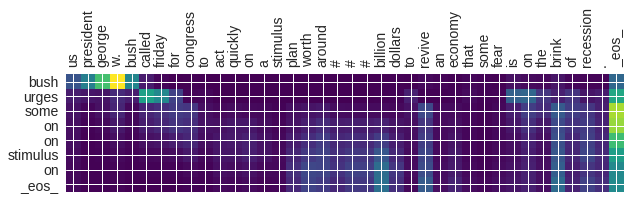

1
Input: south korean share prices closed # . # # percent higher wednesday with early gains driven by an overnight wall street rally tapering off due to a lack of follow - through support , dealers said . _eos_ 

Original summary: seoul shares close # . # # percent higher _eos_ 

Predicted summary: seoul shares close # . # # percent higher _eos_


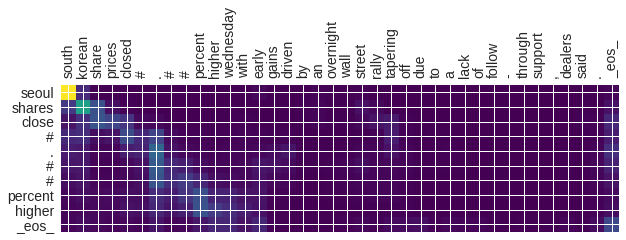

2
Input: italy 's auto giant fiat will lay off between # , # # # and # , # # # workers temporarily in may and june to cut production following slackened demand on the domestic market . _eos_ 

Original summary: italian auto maker to cut vehicle production _eos_ 

Predicted summary: auto auto to cut cut # # # _eos_


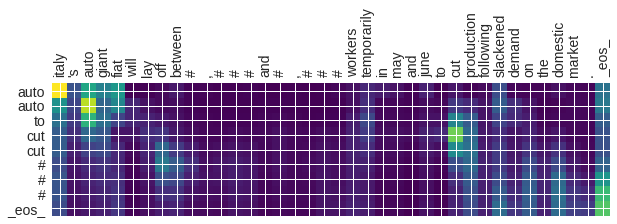

In [45]:
# Luong (Global Dot) Attention
x,y = next(iter(model_data.trn_dl))
for i in range(3):
    print(i)
    preds, attention, encoder_embedding = generate(x.transpose(1,0)[i].unsqueeze(1).contiguous(), 
                                                   y.transpose(1,0)[i].unsqueeze(1), 
                                                   learn_luong)

## Analysis
One of the immediate problems we can observe from the generated summaries is that they are not coherent and there are a lot of repeated phrases or words. Those are very common problems in this type of models and that is why text summarization is still an active area of research. 

## References
- [Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks](https://arxiv.org/abs/1506.03099)
- [Using the Output Embedding to Improve Language Models](https://arxiv.org/pdf/1608.05859.pdf)
- [Abstractive Text Summarization using Sequence-to-sequence RNNs and Beyong](https://arxiv.org/pdf/1602.06023.pdf)
- [Effective Approaches to Attention-based Neural Machine Translation
](https://arxiv.org/pdf/1508.04025.pdf)
- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
- [Learn more about teacher forcing in RNNs](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/)
- [Your TL;DR by an AI: A Deep Reinforced Model for Abstractive Summarization](https://www.salesforce.com/products/einstein/ai-research/tl-dr-reinforced-model-abstractive-summarization/)

## Credit
Please note that the credit for this notebook goes to GitHub username [alesee](https://github.com/alesee/abstractive-text-summarization). I merely added a few more explanations to the code sections and added a few minor fixes. I thank the author for releasing the code, which is hosted [here](https://github.com/alesee/abstractive-text-summarization/blob/master/abstractive-text-summ.ipynb).